In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "device=gpu2, floatX=float32"
import pickle

import theano
import theano.tensor as T
import cv2

%load_ext autoreload
%autoreload 2

import MyConfig
import VGGNet
import BGsubstract

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN Z (CNMeM is disabled, cuDNN 5110)


In [2]:
def loadImgList(dataPath, data_ext):
    files = [f for f in os.listdir(dataPath) if os.path.isfile(dataPath + f)]
    files = [i for i in files if i.endswith('.'+data_ext)]
    return files

In [3]:
def getTrainingDatafromSet(filename, scaleRatio):
    img_pil = Image.open(filename)
    img_pil = img_pil.resize((int(scaleRatio*img_pil.size[0]),int(scaleRatio*img_pil.size[1])), Image.ANTIALIAS)

    img = np.asarray(img_pil, dtype=theano.config.floatX)
    img = img[:,:,0:3]
    return img.transpose(2,0,1).reshape((1,3,img.shape[0],img.shape[1]))

In [4]:
def getLabelfromSet(filenameMsk, scaleRatio):
    imgMask_pil = Image.open(filenameMsk)
    imgMask_pil = imgMask_pil.resize((int(scaleRatio*imgMask_pil.size[0]),int(scaleRatio*imgMask_pil.size[1])), Image.ANTIALIAS)

    imgMask = np.asarray(imgMask_pil, dtype=theano.config.floatX)
    imgMask = imgMask[:, :, 0]
    imgMask[imgMask>0]=1
    imgMask = imgMask[::4, ::4]
    imgMask = imgMask[1:-1, 1:-1]
    return imgMask

In [5]:
imgPath = MyConfig.test_imgPath
labelPath = MyConfig.test_labelPath
testing_images = loadImgList(imgPath, MyConfig.test_fileExt)
nb_testing_images =len(testing_images)


In [6]:
x = T.tensor4('x')
mNet = VGGNet.VGG(x)
x_activ = mNet.activation_volume
mBGsub = BGsubstract.BGsubstract(x_activ,False)

p_fb = mBGsub.p_fb
predict = theano.function([x], p_fb)

VGGNet.py:46: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  p1 = theano.tensor.signal.pool.pool_2d(c12, ds = (2,2), st = (2,2), ignore_border=True)
VGGNet.py:46: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  p1 = theano.tensor.signal.pool.pool_2d(c12, ds = (2,2), st = (2,2), ignore_border=True)
VGGNet.py:50: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  p2 = theano.tensor.signal.pool.pool_2d(c22, ds = (2,2), st = (2,2), ignore_border=True)
VGGNet.py:50: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  p2 = theano.tensor.signal.pool.pool_2d(c22, ds = (2,2), st = (2,2), ignore_border=True)
VGGNet.py:55: UserWarning: DEPRECATION: the 'ds' parameter is no

0 ,  000000131084.png  has cost =  12.8376321793


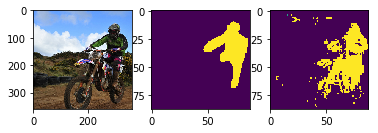

1 ,  000000262146.png  has cost =  8.1761713028


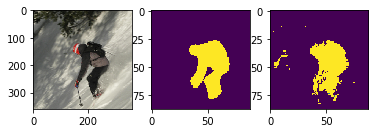

2 ,  000000393227.png  has cost =  14.4537811279


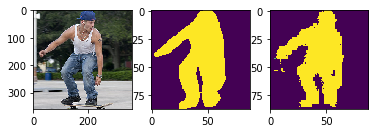

3 ,  000000393230.png  has cost =  4.37135648727


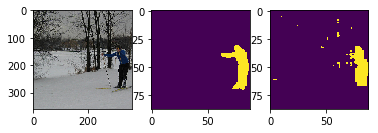

4 ,  000000524297.png  has cost =  11.9704008102


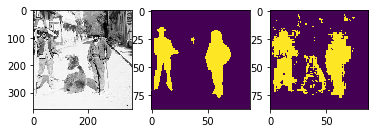

In [8]:
# params_bg = pickle.load(open('./models/paramsBG_noCrowd.pickle'))
params_bg = pickle.load(open(MyConfig.outputPath+MyConfig.paramFileName+'.pickle'))
mBGsub.setParams(params_bg)

import random
sampleNum = nb_testing_images
for idx, imgName in enumerate(testing_images[0:0+sampleNum]):
    x_test = getTrainingDatafromSet(imgPath+imgName, 1)
    prediction = predict(x_test)
    gt = getLabelfromSet(labelPath+imgName, 1)
    
    gtMask = gt
    gtMask[gt>0]=1

    tensorMask = np.empty((1,2,gtMask.shape[0],gtMask.shape[1]),dtype=theano.config.floatX)
    tensorMask[0,0]=gtMask
    tensorMask[0,1]=1.-gtMask     

    ce = T.mean(T.nnet.categorical_crossentropy(prediction,tensorMask))
    ce = ce.eval()

    print idx, ', ', imgName, ' has cost = ', ce

    #show some results
    img_pil = Image.open(imgPath+imgName)
    pred_img = Image.fromarray(np.uint8(prediction[0,0]*255.))

    fig = plt.figure()
    axis1 = fig.add_subplot(131)
    plt.imshow(img_pil)
    axis2 = fig.add_subplot(132)
    plt.imshow(gt)
    axis3 = fig.add_subplot(133)
    plt.imshow(pred_img)
    plt.show()